In [9]:
import sys
from pathlib import Path
ROOT = Path().resolve().parent.parent

sys.path.append(str(ROOT))

In [10]:
from src.model.data_handler import Dataset

dataset = Dataset(csv_data=ROOT / 'data/rec_data_description.csv', IMAGE_SIZE=(64, 64), include_filter=True)

object_types = ['nebula', 'galaxy']

train, val, test, scalers = dataset.get_splits(
    train_ratio=0.70, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    random_state=42,
    object_types=object_types,
    normalize_metrics=True
)

/Users/luisvalenzuela/Documents/Programs/Memoria/src/preprocess/image_quality_metrics.py:19: RuntimeWarning: invalid value encountered in divide
  data = (data - data.min()) / (data.max() - data.min()) * 255
/Users/luisvalenzuela/Documents/Programs/Memoria/venv_base/lib/python3.10/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/luisvalenzuela/Documents/Programs/Memoria/venv_base/lib/python3.10/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [11]:
from src.model.utils.prepare_data import prepare_data_for_model

grouped = True
include_filtered = False
y_score = 'ssim'

x_test, y_test = prepare_data_for_model(test, include_filtered=include_filtered, grouped=grouped, score=y_score)

## Using your own reconstructed images

If you already have reconstructed images, you do not need to run the previous cells. You can start directly from here. 

Simply load your reconstructed images (all from the same visibility/observation) and prepare them for comparison:

In [86]:
import cv2
import numpy as np

def preprocess_image(img, size=64, from_bgr=False):
    """Return a (size,size) float32 image from (H,W[,C]) input."""
    if img.ndim == 3 and img.shape[-1] == 1:
        img2d = img[..., 0]
    elif img.ndim == 3 and img.shape[-1] == 3:
        code = cv2.COLOR_BGR2GRAY if from_bgr else cv2.COLOR_RGB2GRAY
        img2d = cv2.cvtColor(img, code)
    elif img.ndim == 3 and img.shape[-1] == 4:
        code = cv2.COLOR_BGR2GRAY if from_bgr else cv2.COLOR_RGB2GRAY
        img2d = cv2.cvtColor(img[..., :3], code)
    elif img.ndim == 2:
        img2d = img
    else:
        raise ValueError(f"Forma no soportada: {img.shape}")

    img_resized = cv2.resize(img2d, (size, size), interpolation=cv2.INTER_AREA)
    if img_resized.dtype in (np.float32, np.float64):
        img_resized = np.clip(img_resized, 0.0, 1.0).astype(np.float32)
    else:
        img_resized = (img_resized.astype(np.float32) / 255.0)
    return img_resized  # (size, size)

In [ ]:
# Here you can add the images you want to evaluate.
# IMPORTANT: all images must come from the same visibility/observation
# (i.e., different reconstructions of the same visibility).
for img in [x_test[0][0], x_test[0][1], x_test[0][2]]:
    proc_img = preprocess_image(img, 64, from_bgr=False)

test_group = x_test[10]
test_group = np.array([preprocess_image(img, 64, from_bgr=False) for img in test_group])
test_group = test_group[None, ...]
print("Group shape:", test_group.shape)

Group shape: (1, 8, 64, 64)


In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_sorted_by_ssim(test_group, pred, cmap='inferno'):
    group_num = test_group.shape[1]
    ssim_scores = pred[0, :, 0]

    # Sort indices (descending order)
    sorted_idx = np.argsort(ssim_scores)[::-1]

    fig, axs = plt.subplots(1, group_num, figsize=(3 * group_num, 4))

    for j, idx in enumerate(sorted_idx):
        img = test_group[0, idx]
        # Remove channel axis if present
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        axs[j].imshow(img, cmap=cmap)
        axs[j].set_title(f'Image {idx+1}\nSSIM: {ssim_scores[idx]:.4f}', fontsize=18)
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

### Predict with no-context model

In [89]:
from tensorflow import keras

# Change the model name to psnr_no_context_model.keras if want PSNR predicitions
model_no_context = keras.models.load_model("ssim_no_context_model.keras") 

In [90]:
pred = model_no_context.predict(test_group)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


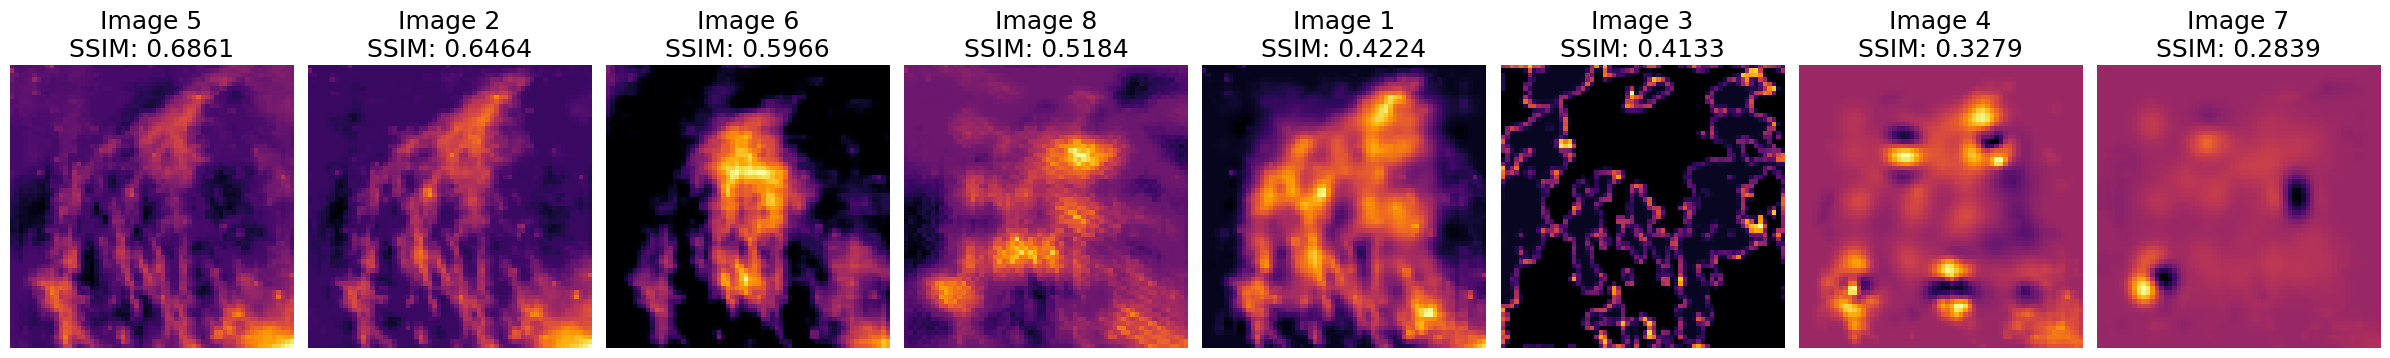

In [91]:
plot_group_sorted_by_ssim(test_group, pred)

### Predict with context model

In [92]:
import tensorflow as tf
from tensorflow.keras import layers

class TimeReduceMean(layers.Layer):
    def call(self, z):
        return tf.reduce_mean(z, axis=1, keepdims=True)
    def compute_output_shape(self, s):
        return (s[0], 1, s[2])
    def get_config(self):
        return super().get_config()

class TimeReduceMax(layers.Layer):
    def call(self, z):
        return tf.reduce_max(z, axis=1, keepdims=True)
    def compute_output_shape(self, s):
        return (s[0], 1, s[2])
    def get_config(self):
        return super().get_config()

class TileToTime(layers.Layer):
    def call(self, inputs):
        ref, ctx = inputs
        T = tf.shape(ref)[1]
        return tf.tile(ctx, [1, T, 1])
    def compute_output_shape(self, s):
        return (s[0][0], s[0][1], s[1][2])
    def get_config(self):
        return super().get_config()

In [93]:
from tensorflow import keras

# Change the model name to psnr_context_model.keras if want PSNR predicitions
model_context = keras.models.load_model(
    "ssim_context_model.keras",
    custom_objects={
        "TimeReduceMean": TimeReduceMean,
        "TimeReduceMax": TimeReduceMax,
        "TileToTime": TileToTime
    },
    compile=False
)

In [94]:
pred_ctx = model_context.predict(test_group)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


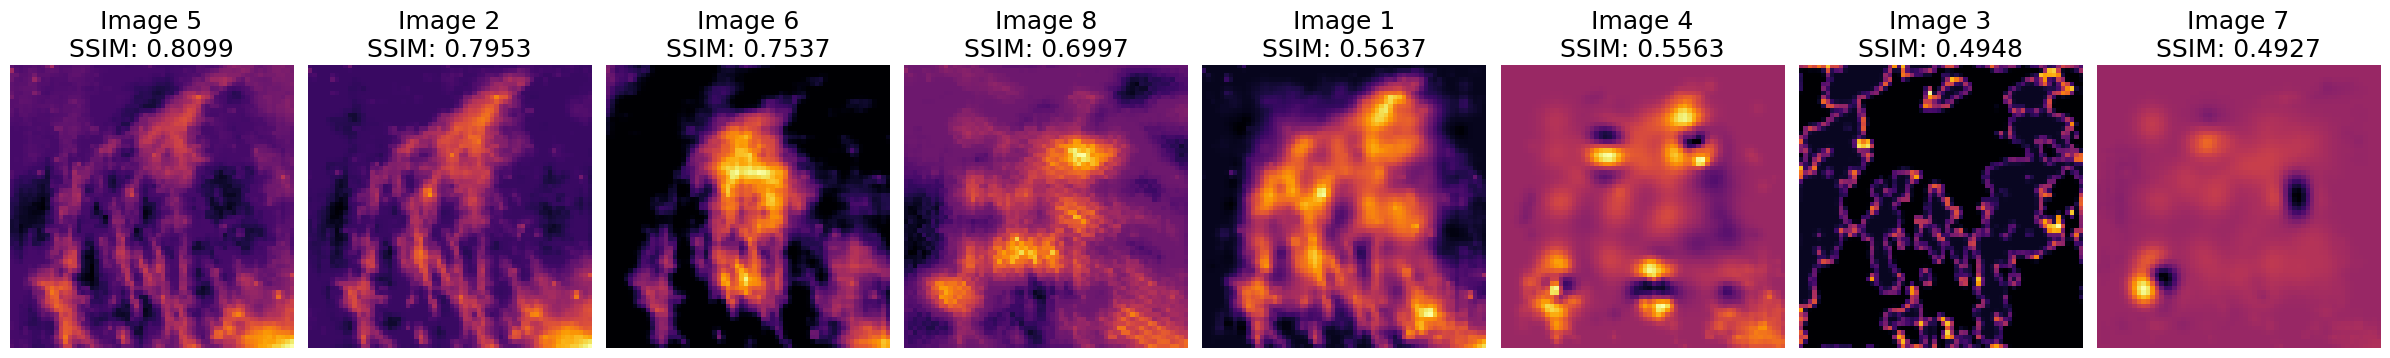

In [95]:
plot_group_sorted_by_ssim(test_group, pred_ctx)